Hunter Bennett | Strains Project | 20 April 2021

Analyzing H3K27Ac data (old) with new strains ATAC data.

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

In [2]:
dataDirectory = '/home/h1bennet/strains/data/H3K27Ac/'
workingDirectory = '/home/h1bennet/strains/results/06_Strains_Control_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


# Copy over merged ATAC-seq peaks from ATAC-seq analysis.

In [3]:
%%bash

# if directories don't exist, create them
if [ ! -d ./merged_peaks/ ]; then mkdir ./merged_peaks; fi

cp /home/h1bennet/strains/results/06_Strains_Control_Cohort2_ATAC/merged_peaks/idr_peaks_merged.txt \
./merged_peaks/idr_peaks_merged.txt

# Annotate peaks with H3K27Ac data

Optional: drop files from analysis here by including tag directory in the list

In [4]:
drop_files = ['NaN']

# drop_files = ['']

In [5]:
# grab relevant tag directories
tagdirs = np.sort(glob.glob('/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/*H3K27Ac*'))

tagdirs = pd.Series(tagdirs)[~pd.Series(tagdirs).str.contains('|'.join(drop_files))].tolist()

In [6]:
with open('./annotatePeaks_homer.sh', 'w') as f:
    annotate_raw = ['annotatePeaks.pl', './merged_peaks/idr_peaks_merged.txt',
                       'mm10', '-size 1000', '-raw', '-d \\\n',
                       ' \\\n'.join(tagdirs), '>',
                       './merged_peaks/ann_raw_kc_control_atac_peaks_all.txt &\n\n']
    
    annotate_norm = ['annotatePeaks.pl', './merged_peaks/idr_peaks_merged.txt',
                       'mm10', '-size 1000', '-norm 1e7', '-d \\\n',
                       ' \\\n'.join(tagdirs), '>',
                       './merged_peaks/ann_norm_kc_control_atac_peaks_all.txt &\n\n']
    
    f.write(' '.join(annotate_raw))    
    f.write(' '.join(annotate_norm))
    
    f.close()

# Summary plots

In [7]:
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

### Read in annotation files

In [8]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_norm_kc_control_atac_peaks_all.txt')

# shorten columns to make labeling nicer
mat.columns = mat.columns.str.split('/').str[-1]

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

Filter low tag peaks prior to making summary plots

In [9]:
# use group based mat filter - have to set manually
print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
groups=[[0,1], [2,3], [4,5]]
peaks = []
for group in groups:
    peaks.extend(mat.loc[mat.iloc[:, group].mean(1) > 5, :].index.tolist())
mat = mat.reindex(list(set(peaks)))
mat = mat.dropna(how='all')
mat_quant = mat_quant.reindex(list(set(peaks)))
mat_quant = mat_quant.dropna(how='all')
print(mat.shape[0], 'total peaks')

mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
mat_distal.dropna(inplace=True)

df_distal = df.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
df_distal.dropna(inplace=True)

84264 total peaks
filtering low tag count peaks
75588 total peaks


### Mean variance plot

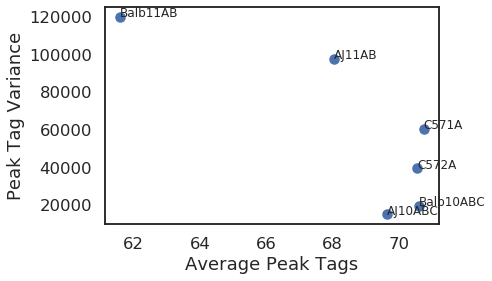

In [10]:
ax = plt.scatter(mat.mean(), mat.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat.mean(),
            mat.var(),
            mat_quant.columns.str.split('_').str[6],
            plt.gca())

plt.savefig('./figures/mean_variance_plot.png',
            bbox_inches='tight')

### Try with quantile normalized data

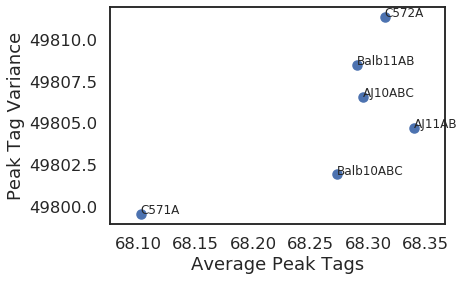

In [11]:
ax = plt.scatter(mat_quant.mean(), mat_quant.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat_quant.mean(),
            mat_quant.var(),
            mat_quant.columns.str.split('_').str[6],
            plt.gca())

plt.savefig('./figures/mean_variance_plot_quantnorm.png',
            bbox_inches='tight')

### Correlation heatmap

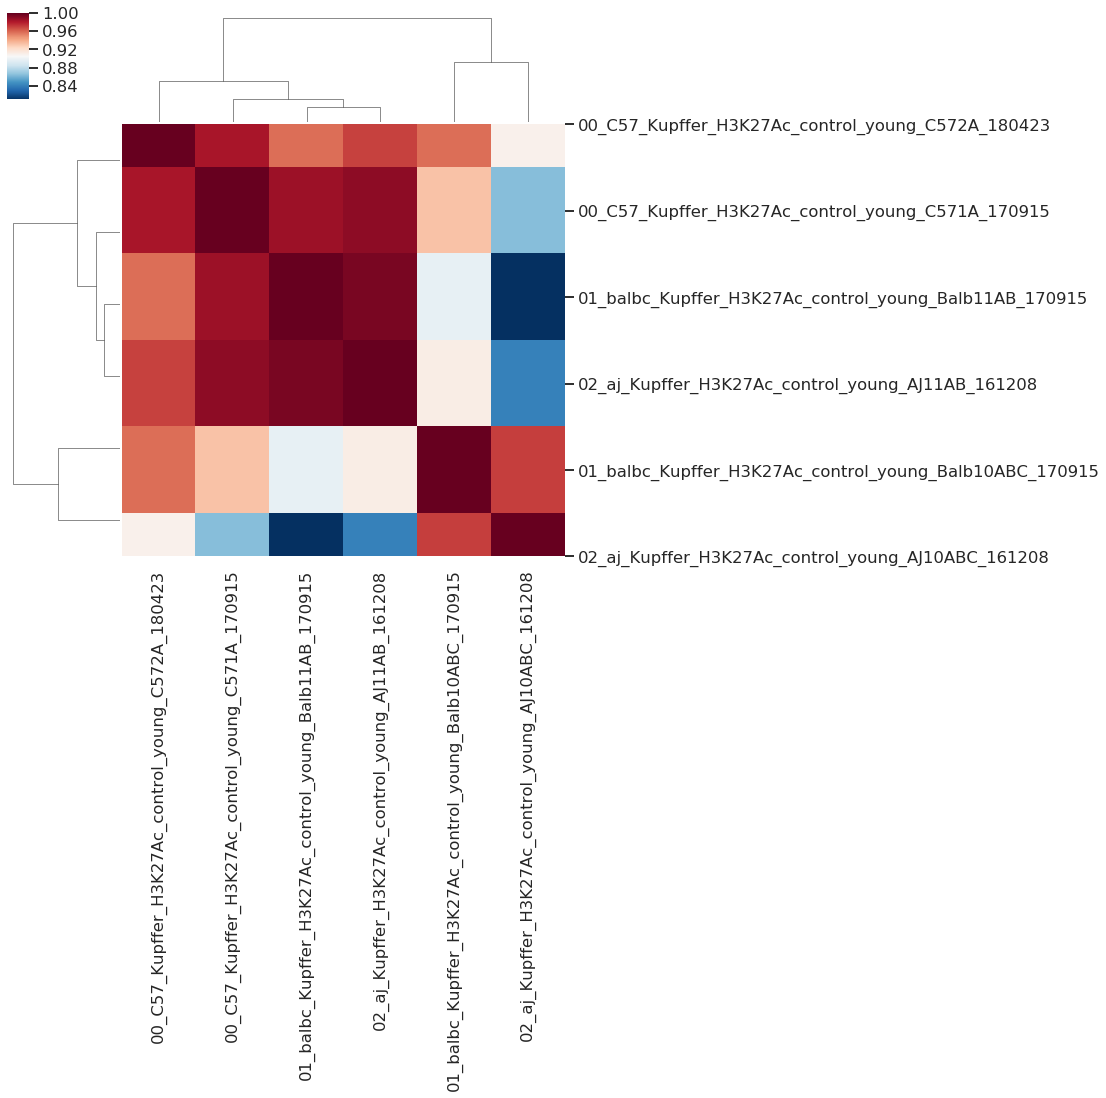

In [12]:
cm = sns.clustermap(mat.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/h3k27ac_correlation_heatmap.png', bbox_inches='tight')

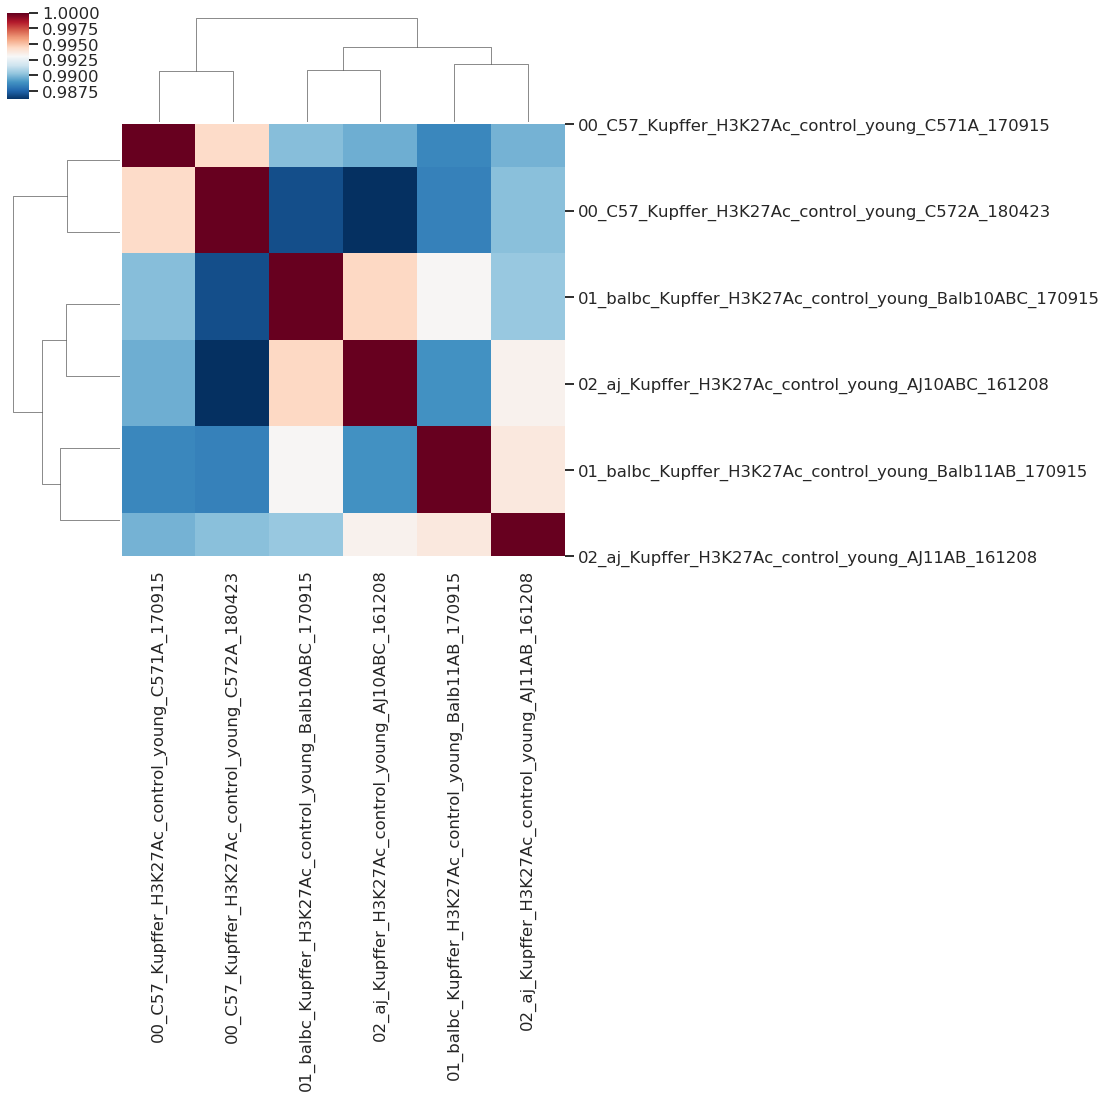

In [13]:
cm = sns.clustermap(mat_quant.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/h3k27ac_correlation_heatmap_quantnorm.png', bbox_inches='tight')

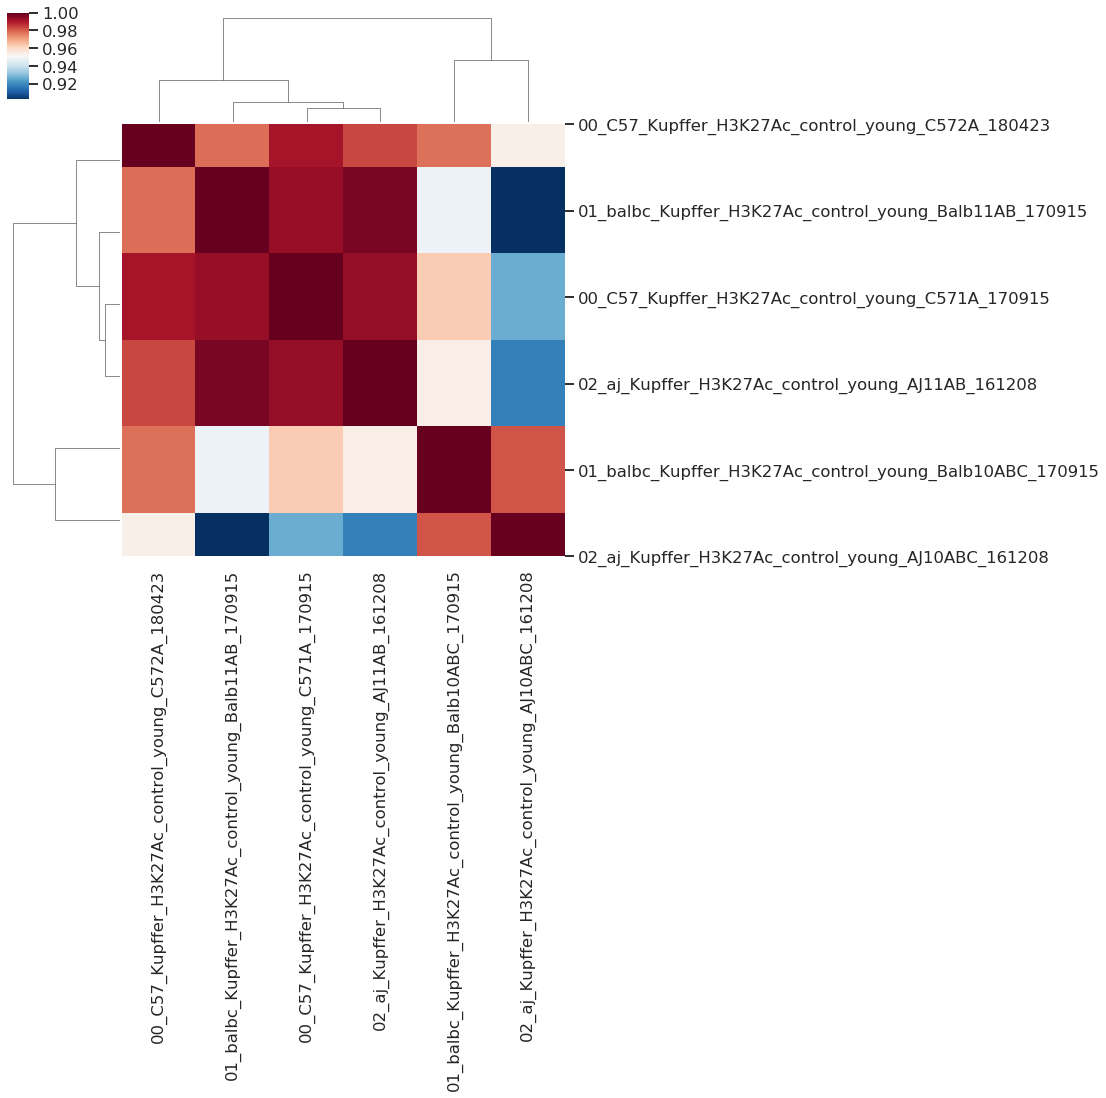

In [14]:
cm = sns.clustermap(mat_distal.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/h3k27ac_correlation_distal_heatmap.png', bbox_inches='tight')

# Principal Component Analysis

Create sample ID data frame for ease of plotting

In [15]:
# this part must be done manually - use the sample ID fields to pick out
# identifiers for each sample.
samples = pd.Series(mat.columns.str.split('/').str[-1])
group = samples.str.split('_').str[0]
strain = samples.str.split('_').str[1]
cell = samples.str.split('_').str[2]
treatment = samples.str.split('_').str[4]
treatment_time = samples.str.split('_').str[5]
mouseid = samples.str.split('_').str[6]
sampledate = samples.str.split('_').str[7]
                                        
samplesDF = pd.DataFrame([pd.Series(samples),
                          pd.Series(group),
                          pd.Series(strain),
                          pd.Series(cell),
                          pd.Series(treatment),
                          pd.Series(treatment_time),
                          pd.Series(mouseid),
                          pd.Series(sampledate)],
                         index=['mouse', 'group', 'strain', 'celltype',
                                'treatment', 'treatment_time', 'mouse_id',
                                'sample_date']).T

### Look at PCA plots for all the samples

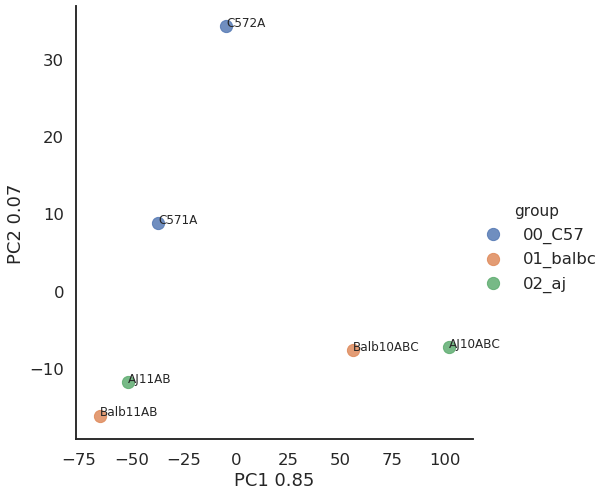

In [16]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
                                 group_labels=samplesDF.group+'_'+samplesDF.strain,
                                 plot_size=7,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/h3k27ac_pca1_pca2.png', bbox_inches='tight')

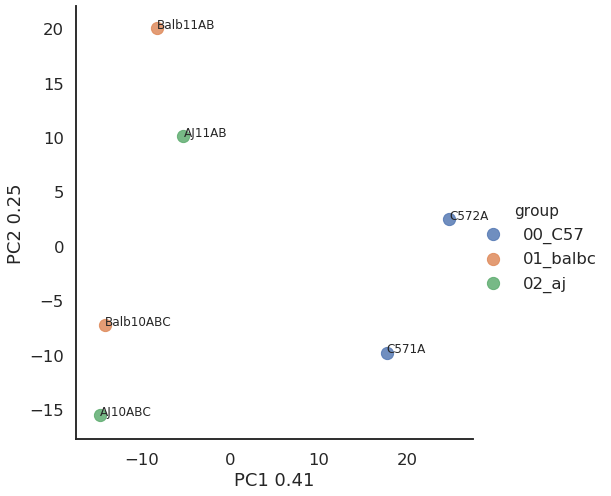

In [17]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_quant,
                                 group_labels=samplesDF.group+'_'+samplesDF.strain,
                                 plot_size=7,
                                 n_pca=3)
label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/h3k27ac_pca1_pca2_quantnorm.png', bbox_inches='tight')

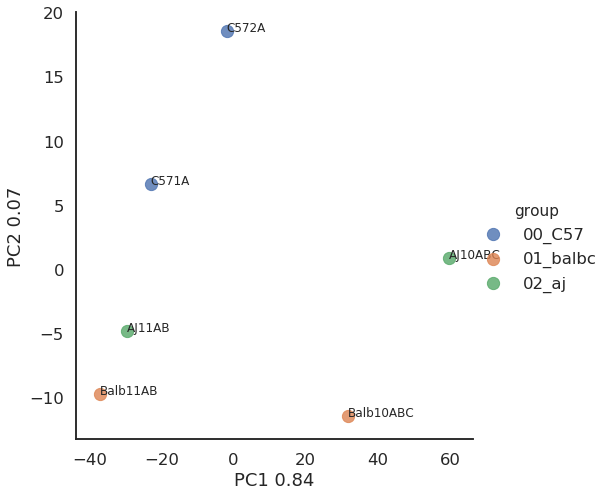

In [18]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_distal,
                                 group_labels=samplesDF.group+'_'+samplesDF.strain,
                                 plot_size=7,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/h3k27ac_distal_pca1_pca2.png', bbox_inches='tight')

We only have two replicates for all strains so no filtering today!

# Make venn diagram of 'active' enhancers

In [19]:
from matplotlib_venn import venn3

In [20]:
groups = ['C57Bl6J', 'BALBcJ', 'AJ']
columns = [[0,1],
           [2,3],
           [4,5]]

avg_tags = {}

for group, col in zip(groups, columns):
    avg_tags[group] = mat.iloc[:, col].mean(1)
    
avg_tags_df = pd.DataFrame(avg_tags)

In [21]:
thresh=32

peak_dict = {}
for col in avg_tags_df.columns:
    peak_dict[col] = avg_tags_df.index[avg_tags_df[col]>thresh].tolist()

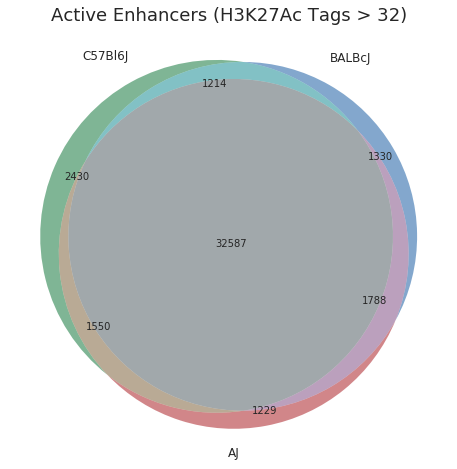

In [22]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=[set(peak_dict['C57Bl6J']),
               set(peak_dict['BALBcJ']),
               set(peak_dict['AJ'])],
      set_colors=('#006d2c', '#08519c', '#a50f15'),
      set_labels=('C57Bl6J', 'BALBcJ', 'AJ'),
      alpha=0.5,
      ax=ax)
ax.set_title('Active Enhancers (H3K27Ac Tags > %d)' % thresh);

plt.savefig('./figures/venn3_activated_peaks.png', bbox_inches='tight')

In [23]:
# # use the code below if you'd like to find the specific peak sets shown in the Venn diagram.
# all3 = set(peak_dict['C57Bl6J']).intersection(set(peak_dict['BALBcJ']).intersection(peak_dict['AJ']))
# C57Bl6J_BALBcJ = set(peak_dict['C57Bl6J']).intersection(set(peak_dict['BALBcJ']).difference(all3))
# C57Bl6J_AJ = set(peak_dict['C57Bl6J']).intersection(set(peak_dict['AJ']).difference(all3))
# BALBcJ_AJ = set(peak_dict['BALBcJ']).intersection(peak_dict['AJ']).difference(all3)
# C57Bl6J_private = set(peak_dict['C57Bl6J']).difference(set(all3).union(set(C57Bl6J_BALBcJ).union(C57Bl6J_AJ)))
# BALBcJ_private = set(peak_dict['BALBcJ']).difference(set(all3).union(set(C57Bl6J_BALBcJ).union(BALBcJ_AJ)))
# AJ_private = set(peak_dict['AJ']).difference(set(all3).union(set(C57Bl6J_AJ).union(BALBcJ_AJ)))

# Write 'active' enhancers out for analysis with HOMER
___
Should use the same threshold as venn diagram above

In [25]:
# make folder to write enhancers into
if not os.path.isdir('./active_enhancers/'):
    os.mkdir('./active_enhancers/')

### Since these are based on ATAC-seq peaks we want to pull the original ATAC-seq merged peak file

In [26]:
atac_peaks = pd.read_csv('./merged_peaks/idr_peaks_merged.txt', sep='\t', index_col=0)

In [27]:
new_start = []
new_end = []
for index, row in atac_peaks.iterrows():
    center = row.start + int(np.floor((row.end - row.start)/2))
    new_start.append(center - 100)
    new_end.append(center + 100)
    
atac_peaks_200bp = atac_peaks.iloc[:, :4].copy(deep=True)
atac_peaks_200bp['start'] = new_start
atac_peaks_200bp['end'] = new_end
atac_peaks_200bp.index.rename('PeakID', inplace=True)

# select distal peaks
atac_peaks_200bp_distal = atac_peaks_200bp.reindex(df_distal.index).dropna(how='all')

if np.NaN get introduced into the matrix then it converts 'int' type columns to 'float' type columns, this is not ideal and interferes with downstream peak analysis so we create a dict to change the start and end columns back to integers just in case

In [28]:
convert_dict = {'start': int,
                'end': int}

In [29]:
for col in avg_tags_df.columns:
    tmp = atac_peaks_200bp.reindex(avg_tags_df.index[avg_tags_df[col]>thresh].tolist())
    tmp = tmp.dropna(how='all').iloc[:, :5]
    # convert start and end positions back to integers
    tmp = tmp.astype(convert_dict)
    # filter unknown chromosomes
    tmp = tmp.loc[~tmp.chr.str.contains('random'), :]
    tmp.to_csv('./active_enhancers/'+col+'_active_enhancer_peaks.txt', sep='\t')
    
    tmp = atac_peaks_200bp_distal.reindex(avg_tags_df.index[avg_tags_df[col]>thresh].tolist())
    tmp = tmp.dropna(how='all').iloc[:, :5]
    # convert start and end positions back to integers
    tmp = tmp.astype(convert_dict)
    # filter unknown chromosomes
    tmp = tmp.loc[~tmp.chr.str.contains('random'), :]
    tmp.to_csv('./active_enhancers/'+col+'_active_distal_enhancer_peaks.txt', sep='\t')

# Optional: repeat with samples dropped

In [ ]:
# # import annotation file
# df, mat = read_annotated_peaks('./merged_peaks/ann_norm_kc_control_atac_peaks_all.txt')

# # shorten columns to make labeling nicer
# mat.columns = mat.columns.str.split('/').str[-1]

# # # Optional - drop samples
# dropsamp = ['00_mouse_BL6_M_8week_PU1_ChIP_H3K27Ac_3_AL_20191226_GTAGAG_ds']

# df = df.drop(dropsamp, axis=1)
# mat = mat.drop(dropsamp, axis=1)

# # quantile normalize data
# mat_quant = quantile_normalize_df(mat)

# Once we have settled on tag directories for each group we will make merged tag directories for visualization in the genome browser

In [30]:
# grab relevant tag directories
tagdirs = np.sort(glob.glob('/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/*H3K27Ac*'))

drop_files = ['NaN']

# drop files if necessary
tagdirs = pd.Series(tagdirs)[~pd.Series(tagdirs).str.contains('|'.join(drop_files))].tolist()

In [31]:
# might have to adjust this depending on the sample ids
groups = ['00_C57','01_balbc','02_aj']

In [32]:
with open('./merge_tagdirs.sh', 'w') as f:
    for group in groups:
        tagdirs_to_merge = [i for i in tagdirs if group in i]
        merge_call = ['makeTagDirectory',
                      './merged_tagdirs/'+group+'_Kupffer_H3K27Ac_young_control',
                      '-d \\\n', ' \\\n'.join(tagdirs_to_merge), '\n\n']
        f.write(' '.join(merge_call))
    f.close()

### rename the merged tag directories for upload to UCSC

    cp -r ./merged_tagdirs/00_C57_Kupffer_h3k27ac_young_control ./merged_tagdirs/c57_Kupffer_h3k27ac_young_control
    cp -r ./merged_tagdirs/01_balbc_Kupffer_h3k27ac_young_control ./merged_tagdirs/balbc_Kupffer_h3k27ac_young_control
    cp -r ./merged_tagdirs/02_aj_Kupffer_h3k27ac_young_control ./merged_tagdirs/aj_Kupffer_h3k27ac_young_control

### write command for upload as browser hub

In [4]:
!ls merged_tagdirs

00_C57_Kupffer_h3k27ac_young_control	aj_Kupffer_h3k27ac_young_control
01_balbc_Kupffer_h3k27ac_young_control	balbc_Kupffer_h3k27ac_young_control
02_aj_Kupffer_h3k27ac_young_control	c57_Kupffer_h3k27ac_young_control


    makeMultiWigHub.pl hrb_strains_viz_h3k27ac_merged_young_control_nonumbers mm10 \
    -color 222,45,38 49,130,189 49,163,84 \
    -force -d ./merged_tagdirs/aj_Kupffer_h3k27ac_young_control/ \
    ./merged_tagdirs/balbc_Kupffer_h3k27ac_young_control/ \
    ./merged_tagdirs/c57_Kupffer_h3k27ac_young_control/